# Explainer Notebook

#### Import Appropriate Libraries
We assume that the user has already installed all the appropriate libraries that are used for the data analysis and visualizations

In [1]:
import pandas as pd 
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import plotly.offline as po
po.init_notebook_mode(connected = True)
import plotly.graph_objects as go
import plotly.graph_objs as pg
import plotly.express as px
import panel as pn
pn.extension('tabulator')

import seaborn as sns

from ipywidgets import interact
import hvplot.pandas
import warnings 
import json 
import itertools
warnings.filterwarnings('ignore')

from bokeh.plotting import figure
from bokeh.io import output_notebook, reset_output,show, curdoc, output_file, show
from bokeh.models import ColumnDataSource, HoverTool,Legend, FactorRange,  Slider, CDSView, CustomJS, Row, BooleanFilter, NumeralTickFormatter
from bokeh.models.widgets import Panel, Tabs, MultiChoice, MultiSelect
from bokeh.layouts import column, row
from bokeh.palettes import Dark2_5 as palette

output_notebook()
curdoc().theme = 'dark_minimal'

Loading BokehJS ...

## 1. Motivation.

The Paris Agreement [1],[2] is a binding global climate change agreement whose long-term goal is to limit the increase of global warming to below 2&deg; 
It was first signed in December 2015 and it has been in use since October 2016. In order for this goal to be achieved, the peak of greenhouse emissions first needs to reach its peak as soon as possible, taking into account that still developing countries will need more time. As a second step, with the help of scientific advances, greenhouse emissions should follow rapid reductions in the second half of the 21st century

Based on these goals, we were intrigued to investigate the energy consumption and greenhouse emissions since the application of the Paris Agreement. More precisely, we attempt to analyze the direction of each country separately, in order to deduce which countries are in the right direction and which are the ones that do not meet the expectations. For this purpose, we consider as a starting point the year 2015, when the Paris Agreement was first signed, and handle provided data up to 2020.

The first metric that we introduce is the types of energy that are consumed country-wise and their respective proportions. The types of energy are:

1. **Fossil Fuels**: Coal, Gas and Oil Energy
2. **Low Carbon**: Nuclear, Solar, Hydro and Wind Energy

In order to further investigate which countries are in the first stage, i.e. the stage of increasing their greenhouse emissions for further development, we also introduce the gdp of each country as a factor that we connect with its consumption. 
Lastly, we analyze the greenhouse emissions of each country and its contribution to the total emissions.

### What is your dataset?

**Energy Dataset**<br>
The main dataset that was used for this project, is the complete Energy Dataset that is provided by [Our World in Data](https://ourworldindata.org/energy). This dataset includes data on energy consumption (primary energy, per capita, and growth rates), energy mix, electricity mix and other relevant metrics. The dataset is a collection of data from multiple sources which can be found in [3], and contains energy data for each country from the beginning of the 20st century, up to 2020 (Data about energy consumption for 2021 have not been included yet)

**Countries in Paris Agreement**<br>
Furthermore, in order to filter out the countries that are not part of the Paris Agreement, we extract a dataset from [4], that contains a list of all the countries that have signed the Paris Agreement, along with their population.

**GDP Annual Growth Dataset**<br>
Lastly, during the data processing/analysis of the Energy Dataset, we noticed that particularly data regarding the GDP had a big amount of missing values. Thus, in order to incorporate this information in our data analysis, we used data from the 'GDP annual growth for each country Dataset', provided in [5]. As indicated by its name, this dataset contains the GDP changes for each country during the years, starting from 1960 up to 2020.

**References:**

[1] https://unfccc.int/process-and-meetings/the-paris-agreement/the-paris-agreement/key-aspects-of-the-paris-agreement <br>
[2] https://ec.europa.eu/clima/eu-action/international-action-climate-change/climate-negotiations/paris-agreement_en <br>
[3] https://github.com/owid/energy-data <br>
[4] https://worldpopulationreview.com/country-rankings/paris-climate-agreement-countries <br>
[5] https://www.kaggle.com/datasets/zackerym/gdp-annual-growth-for-each-country-1960-2020

### Why did you choose this/these particular dataset(s)?

We decided to used the Energy Dataset, because it contained a full overview of the energy consumption country-wise during the years. It is a huge dataset (further explanation in the next section), which has already gathered from multiple sources, and grouped them together. This way, we have access to the different types of energy that are consumed during the years, the energy demands of each country, its consumption per capita, the greenhouse-gas emissions and much more info that was not used in this project.<br>

### What was your goal for the end user's experience?

Our main goal is for the user to interactively gain some knowledge about the Paris Agreement and the direction that the countries are in. We want to give the user the ability to select the countries that he/she wants to gain some insights in, with the help of interactive visualizations. Additionaly, we want to include the overall picture of both the greenhouse-gas emissions and energy consumption, in order to let the user make conclusions about its application  

## 2. Basic stats


### Data Cleaning/Preprocessing

#### Load Datasets
All Datasets can be found [here](https://github.com/s213079/explainer_notebook)

In [2]:
# Read Data from csv file
# Load Energy Data
filepath = "owid-energy-data.csv"
data = pd.read_csv(filepath)

# Load countries dataframe, containing the list of countries that have signed the Paris Agreement
countries_filepath = "Paris_agreement_countries.csv"
countries = pd.read_csv(countries_filepath)

# Load in the new annual GDP growth data
gdp = pd.read_csv('GDP_annual_growth.csv')

#### Data Preprocessing

Regarding the preprocessing of the energy dataset, first we only keep the columns that we are interested in (i.e. country, year and multiple consumption types). Furthermore, we only keep the data corresponding to the year range 2015 - 2020, as we want to investigate the advancements that were made after the Paris Agreement was in use. 

**Note**: The extra columns that are being created here are needed for the world-plot that is introduced later. However, data from 2014 are needed so we create these columns here.

Regarding the Countries in Paris Agreement Dataset, we noticed a missalignment in the value of Czech Republic with the Energy Dataset, and thus corrected its name.

In [3]:
# Replace value of Czech Republic so that it is in order with our original Dataframe
countries = countries.replace('Czech Republic','Czechia')

# First remove non-important columns
mask = ['country','year', 'iso_code', 'population', 'coal_consumption', 'gas_consumption', 'oil_consumption', 'solar_consumption', 'nuclear_consumption',
        'wind_consumption', 'hydro_consumption', 'fossil_fuel_consumption','low_carbon_consumption', 'greenhouse_gas_emissions']

df = data[mask]

# Add percentage difference from year to year
df['fossil_fuel_percent']=(df.fossil_fuel_consumption.diff()/df['fossil_fuel_consumption'])*100 #to get percent
df['low_carbon_percent']=(df.low_carbon_consumption.diff()/df['low_carbon_consumption'])*100
df['good_indicator_percent']=df['low_carbon_percent']-df['fossil_fuel_percent']
df['greenhouse_gas_percent']=(df.greenhouse_gas_emissions.diff()/df["greenhouse_gas_emissions"])*100

# Remove all years <2015 and >2020 (as 2021 has no consumption data)
df = df[df['year'] > 2014][df['year'] < 2021]

# Filter by countries of the Paris Agreement
df = df[df['country'].isin(countries['country'])]
df = df.reset_index(drop=True)

We noticed that certain countries (all of them with small population number), had missing data. Thus, we applied further filtering, whith which we drop all countries that during the specified year-period (2015-2020) contained at least one year without any consumption data. On the other hand, in cases of countries that included a few NaN values in certain types of energy consumption for a specifi year, we just considered them to be 0, in order to proceed with our processing and visualizations.

In [4]:
# Get a df only with the consumption columns (of different types)
df_values = df.iloc[:,4:-8]

# Get all indices with only NaN values, as we need to remove the countries that correspond to them
nan_indices = df_values.loc[pd.isnull(df_values).all(1), :].index.values
# Extract all the countries corresponding to nan_indices (unique values)
countries_with_no_data = df.iloc[nan_indices,:]['country'].unique()

# Remove these countries
df = df[~df['country'].isin(countries_with_no_data)]
df = df.reset_index(drop=True)

# Create a list of available countries (used in the visualizations)
selected_countries = df['country'].unique()

Regarding the GDP Dataset, its structure is a bit different, as each year's data is in a separate column. We thus, need to reconstruct it in order for it to have the same structure as our Energy Dataset. We then filter out the countries that do not belong to the df containing Energy Data, which was created above

**Note**: As already stated, 

In [5]:
gdp_mask = ['Country Name','Country Code', '2015', '2016', '2017', '2018', '2019', '2020']
gdp_filtered = gdp[gdp_mask]

gdp_country = gdp_filtered[gdp_filtered['Country Name'].isin(df['country'])]

# Stitch this data set into existing data set
for i, df_row in df.iterrows():
    if df_row['country'] in list(gdp_country['Country Name']):
        reduced = gdp_country[gdp_country['Country Name'] == df_row['country']]
        float(float(reduced[str(df_row['year'])]))
        df.loc[i, 'GDP_growth'] = float(reduced[str(df_row['year'])])
    else:
        df.loc[i, 'GDP_growth'] = np.NaN

### Dataset Stats

The original Energy Dataset contains ~170k rows and 128 columns. After the preprocessing steps presented above we restrict the dataset in 456 rows and 14 columns of interest. We then proceed to create a few bar charts for the different types of energy consumption, as well as for the greenhouse_emissions. More precisely, we want to find worldwide patterns over the different years

In [6]:
types = ['coal_consumption', 'gas_consumption', 'oil_consumption', 'solar_consumption','nuclear_consumption', 'wind_consumption', 'hydro_consumption', 'greenhouse_gas_emissions',]
df_vis = df[['year'] + types]
df_vis = df_vis.groupby(["year"])[types].sum().reset_index()


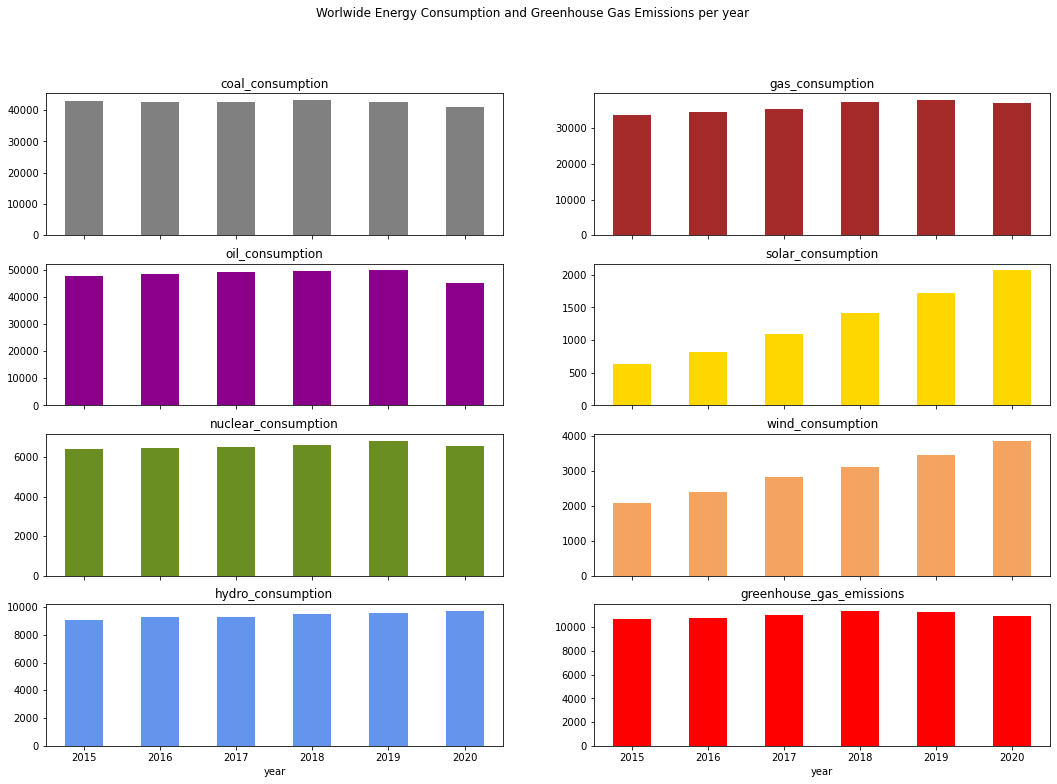

In [7]:
colors1 = [ 'gray', 'brown', 'darkmagenta','gold', 'olivedrab', 'sandybrown',  'cornflowerblue', 'red']
axes = df_vis.plot.bar(x = 'year',rot=0, subplots=True, layout=(4,2), color = colors1, figsize = (18,12), legend = False,
                     title = 'Worlwide Energy Consumption and Greenhouse Gas Emissions per year')

From the bar plots above we can observe a steady increase in the consumption of solar and wind energy. In fact, in the span of 5 years, solar energy consumption has been increased by a factor of 4, while wind consumption has been doubled. However, hydro consumption, which is another form of green energy, follows a much slower increase. 
<br> On the other hand, gas consumption has also been increased in the same time span, while coal and oil consumption shows a signifant decrease in the latest available year (2020).


## 3. Data Analysis

#### What we learned about the Dataset

For each country that has signed the Paris Agreement and for which data is available in our dataset, this will be investigated. The consumption data is given in terra-watt hours per year. 
Since not all countries have published their data or do not appear in the dataset for some other reason, some results should be treated with caution. Therefore, a value of 0.0 should not be taken to mean that a country does not consume any electricity. 

The consumption of certain energy sources was examined in more detail: coal, solar, gas, oil, nuclear, wind and hydro. 
The creators of the data set have also created additional columns in which the climate-neutral energy sources as well as the climate-damaging energy sources are summarised. Nuclear energy is one of the climate-neutral energy sources, which is debatable. In total, the data for 5 years could be compiled for 187 countries.

## 4. Genre

#### Which genre of data story did you use?

As a genre of narrative visualization, we selected a partioned-poster style narrative with a checklist structure. With the use of a multi-view visualization we want to allow the user to explore the story in the order that he/she wishes. The main idea here is to present a fully reader-driven story, while at the same time indicating all the options that a user has and initially presenting some pre-specified countries of interest. An additional idea is to give some notes to the user, in the form of tips, in order to direct him/her and make him/her explore some interesting aspects and options of our narrative.

#### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

The Visual Narrative is separated into the following categories:

1. **Visual Structuring**: Indicates the overall structure of the narrative
2. **Highlighting**: Provides indicators of where the user should pay more focus
3. **Transition Guidance**: Provides mechanisms that enable smooth transitions between different visualizations.

In our website we used the following tools for each category:

1. **Visual Structuring**<br>
Establishing Shot: Presenting the initial visualization with a grid of screenshots from different sections of our presentation, along with accompanying text and labels for each available presentation, we provide an overview of the content that is covered.<br>
Consistent Visual Platform: Throughout the visualizations, the same graphical layout is maintained, while the content is modified.

2. **Highlighting**<br>
Zooming: Both in the World Graph and the Line Plots, the user is allowed to select the range (spatial and temporal respectively) that he/she wishes to further explore.


3. **Transition Guidance**<br>
Continuity Editing: When changing between tabs in the bar plots and line diagrams, the selected filters are still applied, allowing the user to view multiple info of his selections and switch between them.<br>
Viewing Angle: In each visualization, we allow the user to make a selection of countries or rotate the map in the case of the world Data. Thus, the user is presented to a different angle of the presented subject.

#### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

The Narrative Structure can be separated into 3 categories:

1. **Ordering**: Specifies the availability of a certain narrative path
2. **Interactivity**: Provides the tools for manipulating the multiple visualizations
3. **Messaging**: Refers to the way the observations are being communicated 


In our project we used the following tools for each category:

1. **Ordering**<br>
Random Access: There is no specific path indicated to the user enabling him/her to explore different aspects and make his/her own conclusions.

2. **Interactivity**<br>
All the visualizations that were selected rely heavily on interactivity options, in order to further support the reader-driven story. For this reason, we have included the presentation of details while hovering, the ability to filter the displayed results and make a selection of the displayed countries (with the possibilty to search for a specific country), as well as navigation buttons (especially in the world plot). Additionally, we have included a pre-defined list of default values, creating this way default views of our visualizations, particularly for the bar and line plots. Lastly, in order for the user to become accustomed to the interactive possibilities of our visualizations, we provide explicit instructions for each visualization separately.

3. **Messaging**
As our narrative includes many interactive options, we limited the messaging to an introductory text presenting the capabilities of each visualization, and also to a summary, where we further indicate some interesting results that the user may like to explore. However, we chose not to include that much of messaging, in order for the user to also make his/her own conclusions.



## 5. Visualizations.

In order to present the data in the most visual and interesting way for the reader, we decided to choose three different interactive presentations. 

### World-Plot

As the data is geographical, a global representation was of interest. There are several ways to display geographic data via plotly. We decided to use the orthographic representation because it seems the most natural. Plotly is also interactive, which makes this data visualisation fun. In total, three globes were used to display different data. One is the change of climate neutral energy use compared to the previous year in percent. In order to see the other side of the coin, this representation is also shown for climate-damaging energy use. In addition, the third diagram shows the change in greenhouse emissions. This is supposed to be an indicator of whether countries buy energy from other countries in order to "embellish" the figures. 

In [8]:
# First remove non-important columns
mask = ['country','iso_code','year','greenhouse_gas_emissions', 'coal_consumption', 'gas_consumption','oil_consumption', 'solar_consumption', 'nuclear_consumption',
        'wind_consumption', 'hydro_consumption', 'fossil_fuel_consumption','low_carbon_consumption', 'fossil_fuel_percent','low_carbon_percent',
       'good_indicator_percent', 'greenhouse_gas_percent']
df_world = df[mask]
        

In [9]:
# Create Lists for different titles and data columns
title=['Climate negative consumption in percental change to prior year', 'Climate neutral consumption in percental change to prior year','Greenhouse Gas Emissions in percental change to prior year']
color=['fossil_fuel_percent', 'low_carbon_percent','greenhouse_gas_percent']

# Define Global settings
globe_settings={"showframe" : False,
  "fitbounds" : "geojson",
  "showcoastlines" : False,
  "resolution" : 110,
  "projection_type":"orthographic",
  "showcountries" : True,
  "showsubunits":True,
  "subunitcolor":'green',
  "countrycolor": 'black',
  "countrywidth":1.5,
  "showocean" : True,
  "oceancolor": "azure",
  "showlakes": True,
  "lakecolor": '#99c0db',
  "showrivers": True,
  "rivercolor": '#99c0db'}


pipeline_plot1=px.choropleth(df_world,
                    title=title[0],
                    locations ="iso_code",
                    color =color[0],
                    hover_name ="country", 
                    projection='orthographic',
                    color_continuous_scale = px.colors.sequential.Plasma,
                    scope ="world",
                    animation_frame ="year"
                           )

pipeline_plot1.update_layout(coloraxis_colorbar=dict(
    title="change (in percentage)",
    thicknessmode="pixels", thickness=50,
    lenmode="pixels", len=200,
    yanchor="top", y=1,
    ticks="outside",
    dtick=10
))

pipeline_plot1.update_layout(geo=globe_settings, height=600, width=800)

pipeline_plot1.show()

In [10]:
pipeline_plot2=px.choropleth(df_world,
                    title=title[1],
                    locations ="iso_code",
                    color =color[1],
                    hover_name ="country", 
                    projection='orthographic',
                    color_continuous_scale = px.colors.sequential.Plasma,
                    scope ="world",
                    animation_frame ="year"
                           )

pipeline_plot2.update_layout(coloraxis_colorbar=dict(
    title="change (in percentage)",
    thicknessmode="pixels", thickness=50,
    lenmode="pixels", len=200,
    yanchor="top", y=1,
    ticks="outside",
    dtick=10
))

pipeline_plot2.update_layout(geo=globe_settings, height=600, width=800)

pipeline_plot2.show()

In [11]:
pipeline_plot3=px.choropleth(df_world,
                    title=title[2],
                    locations ="iso_code",
                    color =color[2],
                    hover_name ="country", 
                    projection='orthographic',
                    color_continuous_scale = px.colors.sequential.Plasma,
                    scope ="world",
                    animation_frame ="year"
                           )

pipeline_plot3.update_layout(coloraxis_colorbar=dict(
    title="change (in percentage)",
    thicknessmode="pixels", thickness=50,
    lenmode="pixels", len=200,
    yanchor="top", y=1,
    ticks="outside",
    dtick=10
))

pipeline_plot3.update_layout(geo=globe_settings, height=600, width=800)

pipeline_plot3.show()

### Bar-Chart

Inspired by the Youtube channel "Data is beautiful" we also use horizontal bar plots. The user can select countries on the side and easily compare them with each other. There are also three different display options: First, there is a representation where the user can observe the percentage distribution of types of energy consumption for the countries that have already been selected. Since this only shows the percentage of energy sources of a country, we have decided to also show the absolute data. Here, the user can compare the complete energy consumption country by country. As the last part of the bar plot, we have chosen to distinguish between climate-neutral and climate-damaging energy. Additionaly, we enable the user to select the year that he/she desires to be displayed, by introducing a year-slider of the figure.
Such data specifically breaks down how a country's energy consumption is made up. This graph provides a great representation of scale. Countries like Sweden have a high percentage of solar energy that makes up their yearly consumption, but compared to other countries in the absolute view this is ultimately a very small number. This also could provide context for the mentioned emphasis on larger countries (mentioned in the summary on the left) in the Paris Agreement. Larger countries like the United States play such a big role in the energy consumption of the world that it would take many countries changing to see equivalent effect.

**Note:**<br> The multi-choice filter is not shown properly if you are using the dark theme of Jupyterlab. More precisely, in the drop-down menu the options are not very well visible. If you experience such an issue, just swith to the light theme. 

In [12]:
# First keep only important columns
mask = ['country','year','greenhouse_gas_emissions', 'coal_consumption', 'gas_consumption','oil_consumption', 'solar_consumption', 'nuclear_consumption',
        'wind_consumption', 'hydro_consumption', 'fossil_fuel_consumption','low_carbon_consumption']
df_bar = df[mask]

# Data for the first 2 tabs (including different types of energy consumption)
df_filtered1 = df_bar.drop(labels = ['fossil_fuel_consumption', 'low_carbon_consumption'], axis = 1)
types =  ['coal_consumption', 'gas_consumption', 'oil_consumption', 'solar_consumption', 'nuclear_consumption', 'wind_consumption', 'hydro_consumption']

# Create additional columns with the percentages of each type of energy
df_filtered1['total_consumption'] = df_filtered1[types].sum(axis=1)
for i in types:
    df_filtered1['{}_percent'.format(i)] = df_filtered1[i] / df_filtered1['total_consumption']

df_filtered1 = df_filtered1.reset_index(drop=True)

# Data for the first 3rd tab (grouping consumption types in fossil-fuel and low-carbon
df_filtered2 = df[['country','year', 'fossil_fuel_consumption', 'low_carbon_consumption']]
categories = ['fossil_fuel_consumption', 'low_carbon_consumption']

df_filtered2['total_consumption'] = df_filtered2[categories].sum(axis=1)
for i in categories:
    df_filtered2['{}_percent'.format(i)] = df_filtered2[i] / df_filtered2['total_consumption']
    
df_filtered2 = df_filtered2.reset_index(drop=True)

# Some configurations for the plots 
types_percent =  ['coal_consumption_percent', 'gas_consumption_percent', 'oil_consumption_percent', 'solar_consumption_percent',
          'nuclear_consumption_percent', 'wind_consumption_percent', 'hydro_consumption_percent']
colors1 = [ 'gray', 'brown', 'darkmagenta','gold', 'olivedrab', 'sandybrown',  'cornflowerblue']
colors2 = ['firebrick','mediumseagreen']
categories_percent = ['fossil_fuel_consumption_percent', 'low_carbon_consumption_percent']

labels1 = ['Coal', 'Oil', 'Gas', 'Solar','Nuclear', 'Wind', 'Hydropower']
labels2 = ['Fossil Fuel', 'Low Carbon']

initial_countries = ['South Africa', 'China', 'India', 'United States', 'Brazil', 'Canada', 'Sweden', 'United Kingdom', 'France', 'Denmark']
                     
tooltips_percent = [
    ("Country", "@country"),
    ("Coal:", "@coal_consumption_percent{0.00%}"),
    ("Gas:", "@gas_consumption_percent{0.00%}"),
    ("Oil:", "@oil_consumption_percent{0.00%}"),
    ("Solar:", "@solar_consumption_percent{0.00%}"),
    ("Nuclear", "@nuclear_consumption_percent{0.00%}"),
    ("Wind", "@wind_consumption_percent{0.00%}"),
    ("Hydro", "@hydro_consumption_percent{0.00%}"),    
]

tooltips_absolute = [
    ("Country", "@country"),
    ("Coal:", "@coal_consumption{0.00}"),
    ("Gas:", "@gas_consumption{0.00}"),
    ("Oil:", "@oil_consumption{0.00}"),
    ("Solar:", "@solar_consumption{0.00}"),
    ("Nuclear", "@nuclear_consumption{0.00}"),
    ("Wind", "@wind_consumption{0.00}"),
    ("Hydro", "@hydro_consumption{0.00}"),    
]

tooltips_vs = [
    ("Country", "@country"),
    ("Fossil Fuel:", "@fossil_fuel_consumption_percent{0.00%}"),
    ("Low Carbon:", "@low_carbon_consumption_percent{0.00%}"),
      
]

In [13]:
# Data for first 2 tabs
src1 = ColumnDataSource(df_filtered1)

# Data for 3rd tab
src2 = ColumnDataSource(df_filtered2)

# 1st tab: 100% stacked bar chart
fig1 = figure(y_range = selected_countries, title="Energy Consumption Percentage by Country",
           toolbar_location=None, tools="hover", tooltips= tooltips_percent)
# x-range in percent
fig1.xaxis.formatter = NumeralTickFormatter(format='0 %')
# initialize y-range with the pre-selected countires
fig1.y_range = FactorRange(factors=initial_countries)
fig1.xaxis.axis_label = 'Energy Consumption (Percentage)'

# 2nd tab: Stacked bar chart with absolute values
fig2 = figure(y_range = selected_countries, title="Energy Consumption by Country", 
           toolbar_location=None, tools="hover", tooltips = tooltips_absolute)
# initialize y-range with the pre-selected countires
fig2.y_range = FactorRange(factors=initial_countries)
fig2.xaxis.axis_label = 'Energy Consumption (TW-hours)'

# 3rd tab: Stacked bar chart with absolute values
fig3 = figure(y_range = selected_countries, title="Type of Energy Consumption Percentage by Country", 
           toolbar_location=None, tools="hover", tooltips = tooltips_vs)
# initialize y-range with the pre-selected countires
fig3.y_range = FactorRange(factors=initial_countries)
# x-range in percent
fig3.xaxis.formatter = NumeralTickFormatter(format='0 %')
fig3.xaxis.axis_label = 'Energy Consumption (Percentage)'

# Create a slider for the years
year_slider = Slider(start=2015, end=2020, value=2015, step=1, title="Year")

# Filter the src by creating a BooleanFilter (changes in JS code)
year_mask = (df_filtered1['year'] == 2015).tolist()
year_filter = BooleanFilter(booleans = year_mask)

# Boolean filter for the country multichoice widget
country_mask = (df_filtered1['country'].isin(initial_countries)).tolist()
# Initialize the filter with the pre-selected countries
country_filter = BooleanFilter(booleans = country_mask)

# View of the Source that filters the selected year
view1 = CDSView(source= src1, filters=[year_filter, country_filter])

view2 = CDSView(source= src2, filters=[year_filter, country_filter])

# JavaScript Code for the on_change event of the year_slider
year_slider_update = CustomJS(args=dict(f=year_filter, source1 = src1, source2 = src2, slider = year_slider),
                        code="""\
                            const selected_year = slider.value;
                            console.log(selected_year)
                            f.booleans = Array.from(source1.data['year']).map(d => (d == selected_year));
                            console.log(f)
                            source1.change.emit();
                            source2.change.emit();
                            """)

# On-change event of year_slider
year_slider.js_on_change('value', year_slider_update)

# Multichoice widget for country selection
country_choice = MultiChoice(value = initial_countries, options = df_filtered1['country'].unique().tolist(),
                              max_items = 20, title = 'Countries Selected')


# JavaScript Code for the on_change event of the country_multi_choice widget
country_choice_update = CustomJS(args=dict(f=country_filter, source1 = src1, source2 = src2, multi_choice = country_choice,
                                           plot1 = fig1, plot2 = fig2, plot3 = fig3),
                        code="""\
                            const selected_countries = multi_choice.value;
                            console.log(selected_countries)
                            f.booleans = Array.from(source1.data['country']).map(d => (selected_countries.includes(d))); 
                            console.log(Array.from(source1.data['country']))
                            plot1.y_range.factors = selected_countries;
                            plot2.y_range.factors = selected_countries;
                            plot3.y_range.factors = selected_countries;
                            source1.change.emit();
                            source2.change.emit();
                            """)

#callback event of the country filter
country_choice.js_on_change('value', country_choice_update)

# Create horizontal 100% stacked bar for 1st tab
hbar_100stack = fig1.hbar_stack(types_percent, y = 'country', height = 0.75, color = colors1, source=src1, view = view1, legend_label = labels1)

# Create horizontal stacked bar for 2nd tab
hbar_stack = fig2.hbar_stack(types, y = 'country', height = 0.75, color = colors1, source = src1, view = view1, legend_label = labels1)

# Create horizontal 100% stacked bar for 3rd tab
hbar_vs100 = fig3.hbar_stack(categories_percent, y = 'country', height = 0.75, color = colors2, source=src2, view = view2, legend_label = labels2)


# Fix legends
fig1.legend[0].orientation = "horizontal"
fig1.legend[0].click_policy = "mute" 
fig1.add_layout(fig1.legend[0], 'above')

fig2.legend[0].orientation = "horizontal"
fig2.legend[0].click_policy = "mute" 
fig2.add_layout(fig2.legend[0], 'above')

fig3.legend[0].orientation = "horizontal"
fig3.legend[0].click_policy = "mute" 
fig3.add_layout(fig3.legend[0], 'above')

# Create tabs
tab1 = Panel(child= fig1,title="Relative")
tab2 = Panel(child = fig2,title="Absolute")
tab3 = Panel(child = fig3,title="Fossil Fuel vs Low Carbon")
tabs = Tabs(tabs=[tab1, tab2, tab3])

# Create the layout (year slider below the figures)
layout = row(column(tabs,year_slider), country_choice )

curdoc().add_root(layout)
show(layout)

### Line-Plot

There are many factors that lead a country to an increased energy consumption. Countries with many inhabitants, for example, should have a higher energy consumption than countries with few. But the economic strength of a country can also have an impact on energy consumption. We compared these data with the greenhouse emissions and made interesting discoveries. For this we used a line plot with a timeline to see more precisely where the trend is going. This kind of visualisation is perfect for that.
The plot below illustrates GDP, population, greenhouse gas emissions, and their relations to one another over the 5 year span since the Paris Agreement was created. Such data could reveal a correlation between the variables and give context to the difficulty in changing to low carbon emissions. It could be difficult to convince a larger population to make significant change and/or such changes could impact the country negatively in terms of GDP while the transistion occurs.

In [14]:
# Save a variable for countries to use later on
countries_in_use = list(df['country'].unique())

mask = ['country', 'year', 'population', 'greenhouse_gas_emissions', 'GDP_growth']
df_line = df[mask]
# Create new columns with ratios
df_line['GHG-pop'] = df_line['greenhouse_gas_emissions'] / (df_line['population'] / 1000000)
df_line['GHG-gdp'] = df_line['greenhouse_gas_emissions'] / (df_line['GDP_growth'] / 1000000)

In [15]:
# Create 5 figures, 1 for each tab
fig_gdp = figure(title="Country GDP growth per year", y_axis_type="log", x_axis_label = 'Year', y_axis_label = "Log Gross domestic product change in dollars")
fig_pop = figure(title="Country Population per year", x_axis_label = 'Year', y_axis_label = "Population estimate")
fig_ghg = figure(title="Country Green House Gas Emissions", x_axis_label = 'Year', y_axis_label = "Emission in millions of tons of CO2 equivalent")
fig_gdp_to_ghg = figure(title = "Greenhouse Gas Emissions to GDP ratio", x_axis_label = 'Year', y_axis_label = "Million of tons of CO2 equivalent per million dollars")
fig_pop_to_ghg = figure(title = "Greenhouse Gas Emissions to Population ratio", x_axis_label = 'Year', y_axis_label = "Millions of tons of CO2 equivalent per million people")

# Add the figures to a list (will be used as tabs)
plots = [fig_gdp, fig_pop, fig_ghg, fig_gdp_to_ghg, fig_pop_to_ghg]

# A column label (used for referencing columns in for loop)
data_label = ['GDP_growth', 'population', 'greenhouse_gas_emissions', 'GHG-gdp', 'GHG-pop']

# A description of the column for any shown text on the plot (clean text)
description = ['GDP Growth', 'Population', "Greenhouse Gas Emission", 'Greenhouse Gas - GDP ratio', 'Greenhouse Gas - Population ratio']

# Get colors by iterating over a color wheels
colors = itertools.cycle(palette)

# Assign a color to a country and zip them together for use in loop
country_color = []

for color, country in zip(colors, countries_in_use):
    country_color.append((country, color))
 
# Set initial countries
initial_countries = ['South Africa', 'China', 'India', 'United States', 'Brazil', 'Canada', 'Sweden', 'United Kingdom', 'France', 'Denmark']


# Store all possible lines and scatters
plot_lines = []
plot_scatters = []
tab_list = []

# Loop over the tabs (5 of them)
for i, (p, label) in enumerate(zip(plots, data_label)):
    lines = []
    scatters = []
    
    # Loop over the countries for each tab
    for j, (country, color) in enumerate(country_color):
        
        # Create a country specific data source containing only this country's data
        country_specific = df_line[df_line['country'] == country]
        source = ColumnDataSource(country_specific)
        
        # Plot the line and scatter (make visible if in initial_countries)
        if country in initial_countries:
            line = p.line(x = 'year', y = label, color = color, alpha = 1, muted_color = color, muted_alpha=0.2, line_width = 2, source = source)
            lines.append(line)
            
            scatter = p.scatter(x = 'year', y = label, color = color, alpha = 1, muted_color = color, muted_alpha=0.2, size = 8, source = source)
            scatters.append(scatter)
        else:
            line = p.line(x = 'year', y = label, color = color, alpha = 1, muted_color = color, muted_alpha=0.2, line_width = 2, source = source)
            lines.append(line)
            line.visible = False
            
            scatter = p.scatter(x = 'year', y = label, color = color, alpha = 1, muted_color = color, muted_alpha=0.2, size = 8, source = source)
            scatters.append(scatter)
            scatter.visible = False
            
    plot_lines.append(lines)
    plot_scatters.append(scatters)
    
    # For the hover tool in the first 3 tabs we want the comma notation for y
    if (i < 3):
        hover = HoverTool(tooltips=[('Country', '@country'), (f'{description[i]}', '$y{,}')])
        
    # or else we want the normal format for y
    else:
        hover = HoverTool(tooltips=[('Country', '@country'), (f'{description[i]}', '$y')])

    p.add_tools(hover)
    tab = Panel(child = p, title = description[i])
    tab_list.append(tab)
    
tabs = Tabs(tabs = tab_list)

multichoice = MultiChoice(value = initial_countries, options = countries_in_use,
                              max_items = 20)

# If the multichoice's current selection contains a country enable its corresponding line
callback = CustomJS(args=dict(lines=plot_lines, scatters = plot_scatters, countries = countries_in_use, multi=multichoice), 
    code="""
    const choice = multi.value;
    console.log(choice)
    console.log(choice.includes(countries[0]))
    for (let j = 0; j < 5; j++) {
        for (let i = 0; i < lines[0].length; i++) {
            lines[j][i].visible = choice.includes(countries[i])
            scatters[j][i].visible = choice.includes(countries[i])
        }
    }
    """)

multichoice.js_on_change('value', callback)
layout = row(tabs, multichoice)
show(layout)

## 6. Discussion. Think critically about your creation

### What went well?

All in all, we were able to create a great website that interactively draws attention to what we consider to be an important issue. It was a good training to work with many different libraries and to dive deeply into the topic together. The added value that our site generates is, in our opinion, presented in a comprehensible and interesting way. Working with Bokeh in two of the plots led to a great deal more familiarity with the tool beyond the uses in the class. Adding the interactability took some research and time and ultimately we feel much more comfortable with the tool.

### What is still missing? What could be improved? Why?

Visualizing the trend of greenhouse gases over the years the emissions seem to fluctuate quite a bit. This may be a result of natural variance or indicate the direction a country is moving toward. It is ultimately difficult to say with a short time span to make such changes. Changes to types of energy produced and consumed take years to make. Over the years the trend will become more clear but now we can take a look at the current trend and get initial impressions. With more year data further into the Paris Agreement's span the trends would become clearer and the noise or natural variance would also become clearer.

Consideration was been given to training an artificial intelligence to make predictions about greenhouse gas emissions in the future for each country. Unfortunately, this could not be done in time and as stated above the data set is sadly small for such a task. Nevertheless, out of interest, work is being done after the course to see if the paris agreement can be adhered to.

Other points that could be improved are:

1. An addition would be to link the bar plot and line plot, so that they share the multichoice button for the countries selection.
2. In these two plots we could also include worlwide data or grouped by continent, but that required more work as the selection filter had to change
3. Add a regression model to predict the energy consumption of each contry to find out if the paris agreement is reachable.
4. Our website doesn't update automatically, therefor a upload for the "newest" data would be good since the data changes every year.
5. Small note but always nice to have: A night mode.
6. There was a choice made to color based on intensity in the globe plot which in hindsight might have been a bit unintuitive with the year animation because colors change meaning year to year. It makes sense when looking at specific years but the intensities could be coded beforehand to a certain color to maintain a uniform color meaning.

## 7. Contributions

**Rasmus Scott Grunnet-Jepsen**: Part 5 - Line Plot, Creation of Website <br>
**Gabriel Franz Koenig**: Part 3, 5 - World Plot, 6, Creation of Video for Part A <br>
**Panagiotis Apostolidis**: Part 1, 2, 4, 5 - Bar Chart <br>
